In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import OrderedDict 
import json
%matplotlib inline


#step 1 - read saved data, variables DONE
#step 1.5 - ignore comments
#step 2 - read from VD file - net-generation, net-generation by each tech, system cost, net co2 emissions
#step 3 - store each of the above in an array
#step 4 - generate plots

def makecmap(iparray):
    oparray=[]
    for i in iparray:
        if i>0:
            oparray.append('b')
        else:
            oparray.append('r')
    return oparray

nsamples=30
nvar=10

colname=[]
netgen=[]
for i in range(1,10):
    colname.append("col"+str(i))    
co2emi=[]
syscost=[]
techlist=['pws','soec','pemec','sofc','pemfc','ccsg','ccsc']
h2genlist=['pws','soec','pemec']
ordxlist=['pwsi','soeci','pemeci','sofci','pemfci','ccsgi','ccsci','pwsemi','soecemi','pwseff']

ipdat=OrderedDict()
tempip={}
with open('random_samples.json') as fjson:
    temp = json.load(fjson)

for key in ordxlist:
    ipdat[key]=temp[key]
    
ipdat['pwseff'][:] = [x*0.4 for x in ipdat['pwseff'][:]]
ipdat['pwsemi'][:] = [x*1e6 for x in ipdat['pwsemi'][:]]
ipdat['soecemi'][:] = [x*1e6 for x in ipdat['soecemi'][:]]


share={}
op={}
dbkey={}
for key in techlist:
    share[key]=[]
    op[key]=np.zeros((1,nsamples))
dbkey['pws']=['PWS50','H2']
dbkey['soec']=['ECSOEC50','ESOECH2']
dbkey['pemec']=['ECPEM22','EPEMH2']
dbkey['sofc']=['SOFC30','ELC']
dbkey['pemfc']=['PEMFC22','ELC']
dbkey['ccsg']=['LNGCCS22','IMECCSG']
dbkey['ccsc']=['USCCCS23','IMECCSC']

demvals=[913791,880396,866861,872251]
gr1=1.017
gr2=1.01
gr3=1.005

for i in range(14):
    demvals.append(demvals[-1]*gr1)
    
for i in range(20):
    demvals.append(demvals[-1]*gr2)

for i in range(20):
    demvals.append(demvals[-1]*gr3)
    
for i in range(30):
    demvals.append(demvals[-1])
    
netgen=float(np.sum(demvals))
#read data from raw TIMES files
for j in range(1,nsamples+1):
    dbname='sa'+str(j)+'.VD'
    rawdf = pd.read_csv(dbname,comment='*')#, delimiter=',')#, usecols = colfilter)
    rawdf.columns=colname
    cost=rawdf.loc[rawdf.col1=='ObjZ']['col9'].to_numpy()
    emi=rawdf.loc[(rawdf['col1']=='VAR_FOut') & (rawdf['col2']=='ELCCO2')]['col9'].to_numpy()
    emi=float(np.sum(emi))
    syscost.append(float(cost[0]))
    co2emi.append(emi)
    for key in dbkey:
        com=dbkey[key][1]
        proc=dbkey[key][0]
        op[key]=rawdf.loc[(rawdf['col1']=='VAR_FOut') & (rawdf['col2']==com) & (rawdf['col3']==proc)]['col9'].to_numpy()
        if key in h2genlist:
            sval=float(np.sum(op[key]))/1000.0 #value in TWh, not normalized
        else:
            sval=float(np.sum(op[key]))/netgen
#        sval=float(np.sum(op[key]))/1000.0
        share[key].append(sval)



D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


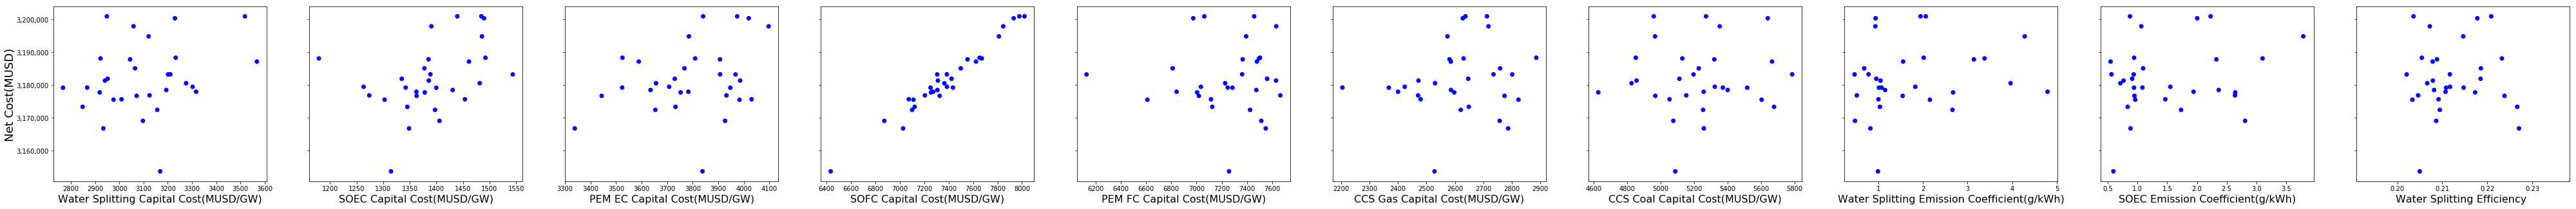

In [2]:
fig,ax=plt.subplots(1,nvar,sharey=True,figsize=(nvar*7,5))

yposXlabel=0.1
xposYlabel=0.07

xposXlabel=[0.13,0.21,0.295,0.37,0.455,0.53,0.61,0.675,0.755,0.845]
yposYlabel=[0.86,0.76,0.65,0.53,0.42,0.31,0.2]

xlabls1=['Water Splitting Capital Cost','SOEC Capital Cost','PEM EC Capital Cost','SOFC Capital Cost',
         'PEM FC Capital Cost', 'CCS Gas Capital Cost', 'CCS Coal Capital Cost','Water Splitting Emission Coefficient',
         'SOEC Emission Coefficient','Water Splitting Efficiency']
xlabls2=['(MUSD/GW)','(MUSD/GW)','(MUSD/GW)','(MUSD/GW)','(MUSD/GW)','(MUSD/GW)','(MUSD/GW)','(g/kWh)','(g/kWh)',' ']
ylabls1=['Water Splitting Output','SOEC Output','PEM EC Output','SOFC Share',
         'PEM FC Share', 'CCS Gas Share', 'CCS Coal Share']
ylabls2=['TWh','TWh','TWh',' ',' ',' ',' ']

for idx, key in enumerate(ipdat):
    xvals=ipdat[key][0:nsamples]
    cmap=makecmap(syscost)
    ax[idx].scatter(xvals,syscost,c=cmap)
    ax[idx].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[idx].set_xlabel(xlabls1[idx]+xlabls2[idx],fontsize='16')

fig.text(0.11,0.5,"Net Cost(MUSD)",rotation='vertical',va='center',fontsize='18')
#for i in range(10):
#    fig.text(xposXlabel[i]*1.01, yposXlabel*0.6, xlabls2[i],fontsize='18')
fig.savefig('syscost.png',bbox_inches='tight', dpi=300)

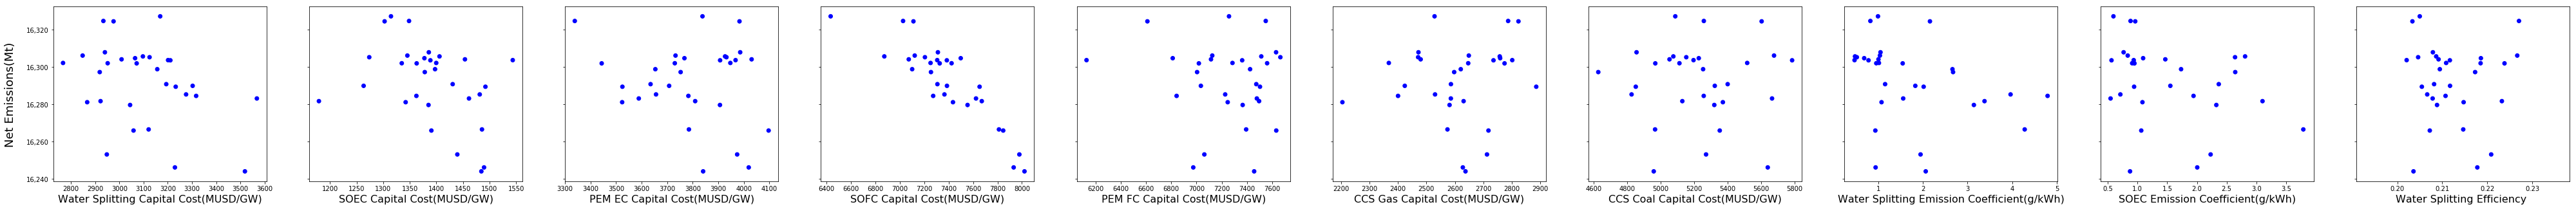

In [3]:
fig2,ax2=plt.subplots(1,nvar,sharey=True,figsize=(nvar*7,5))

for idx, key in enumerate(ipdat):
    xvals=ipdat[key][0:nsamples]
    cmap=makecmap(co2emi)
    ax2[idx].scatter(xvals,co2emi,c=cmap)
    ax2[idx].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2[idx].set_xlabel(xlabls1[idx]+xlabls2[idx],fontsize='16')

fig2.text(0.11,0.5,"Net Emissions(Mt)",rotation='vertical',va='center',fontsize='18')
fig2.savefig('co2emi.png',bbox_inches='tight', dpi=300)

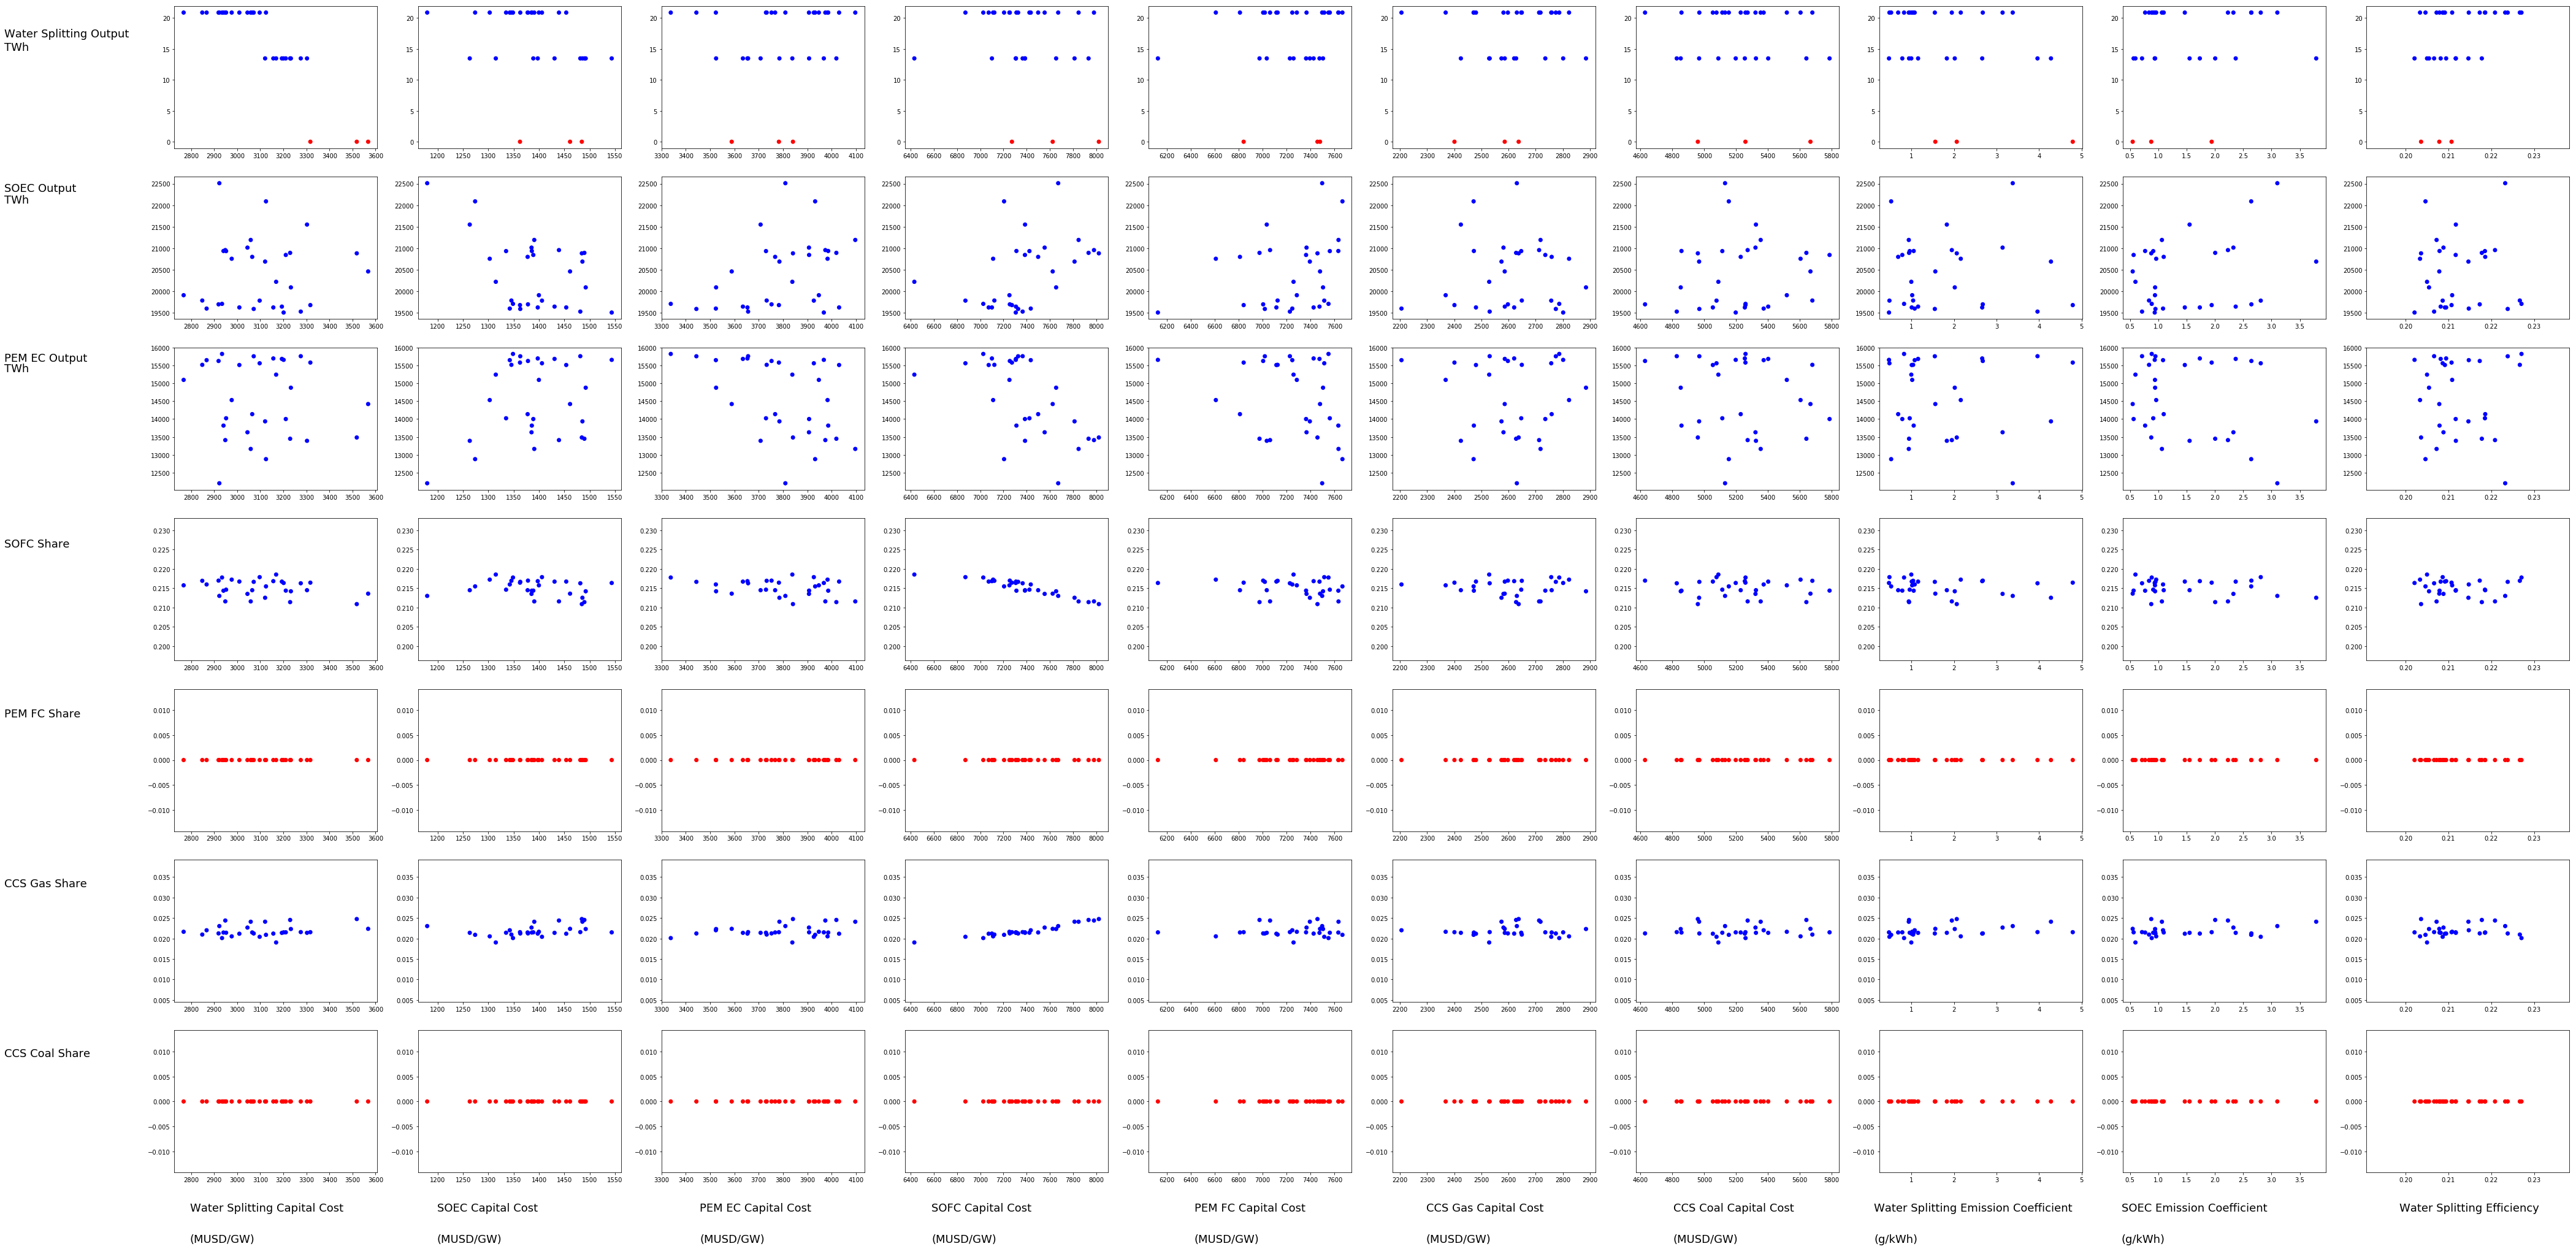

In [4]:
#pws plot
ntech=len(techlist)
fig3,ax3=plt.subplots(ntech,nvar,figsize=(nvar*7,35))

for idx,key in enumerate(share):
    cctr=0
    for key2 in ordxlist:
        xvals=ipdat[key2][0:nsamples]
        cmap=makecmap(share[key])
        ax3[idx][cctr].scatter(xvals,share[key],c=cmap)
#        ax3[idx][cctr].set_xlabel(key2,fontsize='16')
#        ax3[idx][cctr].set_ylabel("Share("+key+")",fontsize='16')
        cctr+=1


for i in range(10):
    fig3.text(xposXlabel[i], yposXlabel, xlabls1[i],fontsize='18')
    fig3.text(xposXlabel[i], yposXlabel*0.8, xlabls2[i],fontsize='18')

for i in range(7):
    fig3.text(xposYlabel, yposYlabel[i], ylabls1[i],fontsize='18')
    fig3.text(xposYlabel, yposYlabel[i]*0.99, ylabls2[i],fontsize='18')


fig3.savefig('techs.png',bbox_inches='tight', dpi=300)